In [1]:
%matplotlib inline

from collections import OrderedDict

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from numpy import count_nonzero as ntrue

plt.style.use('classic')
plt.rcParams.update({
    'figure.figsize': (6, 4), 'figure.facecolor': 'w',
    'figure.subplot.bottom': .125, 'font.size': 10, 'savefig.dpi': 72,
})

def crosstab(df, index, columns, tests=False, margins=True, **kwargs):
    idx = [df[i] for i in index] if isinstance(index, list) else df[index]
    cols = [df[c] for c in columns] if isinstance(columns, list) else df[columns] 
    result = pd.crosstab(idx, cols, margins=margins, **kwargs)
    if tests:
        values = result.iloc[:-1, :-1] if margins else result
        testres = chi2_contingency(values), fisher_exact(values)
        if tests != 'raw':
            label = tests if isinstance(tests, basestring) else '%s & %s' % (index, columns)
            testres = [tr.to_frame(label).T for tr in testres]
            result.expected = pd.DataFrame(testres[0].at[label, 'expected'],
                index=values.index, columns=values.columns)
        result.chi2, result.fisher_exact = testres
    return result

def chi2_contingency(x, func=scipy.stats.chi2_contingency):
    try:
        chi2, p, dof, expected = func(x)
    except ValueError:
        return
    result = chi2, p, dof, expected, (expected >= 5).all()
    return pd.Series(result, index=('chi2', 'p', 'dof', 'expected', 'usable'))

def fisher_exact(x, func=scipy.stats.fisher_exact):
    return pd.Series(func(x), index=('odds', 'p'))

def pearsonr(df, left, right, func=scipy.stats.pearsonr):
    df = df[[left, right]].dropna()
    name = '%s & %s' % (left, right)
    with np.errstate(invalid='ignore'):
        result = func(df[left], df[right])
    return pd.Series(result, index=('r', 'p'), name=name)

FILE = 'portmanteau_analyses.csv'
RENAME = {'Quechua (Ayacucho)': 'Ayacucho', 'Tlachichilco Tepehuan': 'Tepehua', 'Lakhota': 'Lakota'}

df = pd.read_csv(FILE, encoding='utf-8')

df['Language'] = df['Language'].replace(RENAME)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 5 columns):
Language    2818 non-null object
Cell        2818 non-null object
Position    2818 non-null int64
Form        2818 non-null object
Meaning     2818 non-null object
dtypes: int64(1), object(4)
memory usage: 110.1+ KB


In [2]:
df.head(10)

,Language,Cell,Position,Form,Meaning
0,Ainu,1s,-1,ku,SA[+1 +sg]
1,Ainu,1p,1,as,S[+1 +pl]
2,Ainu,2s,-1,e,SAP[-3 +sg]
3,Ainu,2p,-1,eci,SAP[+2]
4,Ainu,x,1,an,S[-1 -2 -3]
5,Ainu,1s->2s,-1,eci,SAP[+2]
6,Ainu,1s->2p,-1,eci,SAP[+2]
7,Ainu,1s->3s,-1,ku,SA[+1 +sg]
8,Ainu,1s->3p,-1,ku,SA[+1 +sg]
9,Ainu,1s->x,-2,ku,SA[+1 +sg]


In [3]:
import itertools

SEP = '->'

def is_local(cellkey, sep=SEP, persons=('1', '2')):
    subj, _, obj = cellkey.partition(sep)
    return any(p in subj for p in persons) and any(p in obj for p in persons)

def is_inverse(cellkey, sep=SEP, hierarchy=('1', '2', '3', '4', 'x')):
    subj, _, obj = cellkey.partition(sep)
    for high, low in itertools.combinations(hierarchy, 2):
        if low in subj and high in obj:
            return True
    return False

def is_inverse_restricted(cellkey, sep=SEP, high=('1', '2'), low=('3', '4', 'x')):
    subj, _, obj = cellkey.partition(sep)
    return any(l in subj for l in low) and any(h in obj for h in high)

def is_inverse_relaxed(cellkey, sep=SEP, high=('1', '2')):
    subj, _, obj = cellkey.partition(sep)
    return any(h in obj for h in high)

def get_slot(cellpos):
    return 'prefix' if cellpos < 0 else 'suffix' if cellpos > 0 else 'stem'

df.insert(2, 'Trans', df['Cell'].str.contains(SEP))
df.insert(3, 'Local', df['Cell'].map(is_local))
df.insert(4, 'Direct', ~df['Cell'].map(is_inverse))
df.insert(6, 'Slot', df['Position'].map(get_slot))
df.insert(9, 'Portmx', df['Meaning'].str.contains(SEP))

df.head(10)

,Language,Cell,Trans,Local,Direct,Position,Slot,Form,Meaning,Portmx
0,Ainu,1s,False,False,True,-1,prefix,ku,SA[+1 +sg],False
1,Ainu,1p,False,False,True,1,suffix,as,S[+1 +pl],False
2,Ainu,2s,False,False,True,-1,prefix,e,SAP[-3 +sg],False
3,Ainu,2p,False,False,True,-1,prefix,eci,SAP[+2],False
4,Ainu,x,False,False,True,1,suffix,an,S[-1 -2 -3],False
5,Ainu,1s->2s,True,True,True,-1,prefix,eci,SAP[+2],False
6,Ainu,1s->2p,True,True,True,-1,prefix,eci,SAP[+2],False
7,Ainu,1s->3s,True,False,True,-1,prefix,ku,SA[+1 +sg],False
8,Ainu,1s->3p,True,False,True,-1,prefix,ku,SA[+1 +sg],False
9,Ainu,1s->x,True,False,True,-2,prefix,ku,SA[+1 +sg],False


In [4]:
df['Language'].nunique()

26

In [5]:
crosstab(df, 'Trans', 'Local')

Local,False,True,All
Trans,,,
False,270,0,270
True,1963,585,2548
All,2233,585,2818


In [6]:
crosstab(df.groupby(['Language', 'Cell'])['Trans', 'Local'].first(),
    'Trans', 'Local')

Local,False,True,All
Trans,,,
False,186,0,186
True,890,241,1131
All,1076,241,1317


In [7]:
df.groupby('Language')['Cell'].nunique().to_frame()

,Cell
Language,
Ainu,42
Aleut,72
Ayacucho,39
Bella Coola,34
Chuckchi,33
Darai,34
Fox,49
Hixkaryana,35
Jaqaru,14


In [8]:
df.groupby(['Language', 'Cell'])['Form'].count()\
    .groupby(level='Language').mean().to_frame('marker/cell')\
    .sort_values(by='marker/cell').describe()

,marker/cell
count,26.000000
mean,1.975917
std,0.659278
min,1.000000
25%,1.443182
50%,1.911855
75%,2.460084
max,3.361111


## Learned lexemes

In [9]:
assert df.groupby(['Language', 'Form', 'Meaning'])['Slot', 'Portmx']\
    .filter(lambda g: (g.apply(pd.Series.nunique) > 1).any()).empty
crosstab(df.groupby(['Language', 'Form', 'Meaning'])['Slot', 'Portmx'].first(), 'Slot', 'Portmx')

Portmx,False,True,All
Slot,,,
prefix,132,50,182
suffix,119,55,174
All,251,105,356


In [10]:
crosstab(df.groupby(['Language', 'Form', 'Meaning'], as_index=False)['Portmx'].first(),
    'Language', 'Portmx')

Portmx,False,True,All
Language,,,
Ainu,9,1,10
Aleut,8,9,17
Ayacucho,6,2,8
Bella Coola,9,2,11
Chuckchi,10,5,15
Darai,9,2,11
Fox,13,4,17
Hixkaryana,7,2,9
Jaqaru,4,5,9


In [11]:
llf = crosstab(df.groupby(['Language', 'Form', 'Meaning', 'Portmx'], as_index=False)\
    ['Local'].agg(lambda x: True if x.all() else False if not x.any() else None)\
    .query('Local == Local'),
    'Language', ['Local', 'Portmx'], margins=False).stack('Local')
llf.join(llf.groupby(level='Language').apply(fisher_exact))\
    .rename_axis('Portmx', axis=1).query('p <= .05')

,Portmx,False,True,odds,p
Language,Local,,,,


In [12]:
dlf = crosstab(df.groupby(['Language', 'Form', 'Meaning', 'Portmx'], as_index=False)\
    ['Direct'].agg(lambda x: True if x.all() else False if not x.any() else None)\
    .query('Direct == Direct'),
    'Language', ['Direct', 'Portmx'], margins=False).stack('Direct')
dlf.join(llf.groupby(level='Language').apply(fisher_exact))\
    .rename_axis('Portmx', axis=1).query('p <= .05')

,Portmx,False,True,odds,p
Language,Direct,,,,


## Transitive occurrences

In [13]:
ct = crosstab(df[df['Trans']], 'Local', 'Portmx', tests=True)
ct

Portmx,False,True,All
Local,,,
False,1725,238,1963
True,528,57,585
All,2253,295,2548


In [14]:
ct.expected

Portmx,False,True
Local,,
False,1735.729592,227.270408
True,517.270408,67.729592


In [15]:
ct.chi2.drop('expected', axis=1)

,chi2,p,dof,usable
Local & Portmx,2.26807,0.132065,1,True


In [16]:
ct.fisher_exact

,odds,p
Local & Portmx,0.782444,0.122239


In [17]:
of = df[df['Trans']].groupby(['Language', 'Local'])\
    ['Portmx'].agg(OrderedDict([('Markers', 'size'), ('Portmx', ntrue)]))
of['Ratio'] = 100 * of['Portmx'] / of['Markers']
of['Ratio (norm)'] = of['Ratio'] / of['Ratio'].sum(level='Language')
of.loc[of['Ratio (norm)'].isnull(), 'Ratio'] = None
ofp = of.reset_index('Local')
of.unstack('Local')

Markers       Portmx            Ratio            Ratio (norm)  \
Local         False True   False True       False      True         False   
Language                                                                    
Ainu             41    12      2     0   4.878049   0.000000     1.000000   
Aleut            66    33     21     0  31.818182   0.000000     1.000000   
Ayacucho         62    22      4     4   6.451613  18.181818     0.261905   
Bella Coola      37    21      3     0   8.108108   0.000000     1.000000   
Chuckchi         29    12      5     4  17.241379  33.333333     0.340909   
Darai            53    20      4     0   7.547170   0.000000     1.000000   
Fox             115    24     14     4  12.173913  16.666667     0.422111   
Hixkaryana       22     6      4     0  18.181818   0.000000     1.000000   
Jaqaru            9     7      3     4  33.333333  57.142857     0.368421   
Jumjum           55    19     12     5  21.818182  26.315789     0.453280   
Karuk            25    11      4     1  16.000000   9.090909     0.637681   
Ket             196    22      0     0        NaN        NaN          NaN   
Kunama          139    47     37     1  26.618705   2.127660     0.925985   
Lakota           42    20      0     2   0.000000  10.000000     0.000000   
Maricopa         16    16      0     0        NaN        NaN          NaN   
Maung           255    18     69     5  27.058824  27.777778     0.493445   
Mordvin          31     9     10     1  32.258065  11.111111     0.743802   
Nocte            22     8      4     2  18.181818  25.000000     0.421053   
Reyesano         32    12      0     0        NaN        NaN          NaN   
Sahu            195    24      0     0        NaN        NaN          NaN   
Siuslawan       178    61     12     1   6.741573   1.639344     0.804396   
Tepehua          56    32      2     9   3.571429  28.125000     0.112676   
Thangmi          39    18      1     3   2.564103  16.666667     0.133333   
Turkana          28    10      4     0  14.285714   0.000000     1.000000   
Wardaman         67    25      8     4  11.940299  16.000000     0.427350   
Yimas           153    76     15     7   9.803922   9.210526     0.515604   

                       
Local           True   
Language               
Ainu         0.000000  
Aleut        0.000000  
Ayacucho     0.738095  
Bella Coola  0.000000  
Chuckchi     0.659091  
Darai        0.000000  
Fox          0.577889  
Hixkaryana   0.000000  
Jaqaru       0.631579  
Jumjum       0.546720  
Karuk        0.362319  
Ket               NaN  
Kunama       0.074015  
Lakota       1.000000  
Maricopa          NaN  
Maung        0.506555  
Mordvin      0.256198  
Nocte        0.578947  
Reyesano          NaN  
Sahu              NaN  
Siuslawan    0.195604  
Tepehua      0.887324  
Thangmi      0.866667  
Turkana      0.000000  
Wardaman     0.572650  
Yimas        0.484396

In [18]:
pd.DataFrame([pearsonr(ofp, 'Local', c) for c  in ['Ratio', 'Ratio (norm)']])

,r,p
Local & Ratio,-0.040995,0.791617
Local & Ratio (norm),-0.277682,0.068004


In [19]:
ctl = crosstab(df[df['Trans']], ['Language', 'Local'], 'Portmx', margins=False)
ctl.join(ctl.groupby(level='Language').apply(chi2_contingency))\
    .rename_axis('Portmx', axis=1).query('usable == 1 & p <= .05')

Portmx          False  True       chi2         p  dof  \
Language Local                                          
Aleut    False     45    21  11.491071  0.000699  1.0   
         True      33     0  11.491071  0.000699  1.0   
Kunama   False    102    37  11.496919  0.000697  1.0   
         True      46     1  11.496919  0.000697  1.0   

Portmx                                                   expected usable  
Language Local                                                            
Aleut    False                        [[52.0, 14.0], [26.0, 7.0]]   True  
         True                         [[52.0, 14.0], [26.0, 7.0]]   True  
Kunama   False  [[110.602150538, 28.3978494624], [37.397849462...   True  
         True   [[110.602150538, 28.3978494624], [37.397849462...   True

In [20]:
ctl.join(ctl.groupby(level='Language').apply(fisher_exact))\
    .rename_axis('Portmx', axis=1).query('p <= .05')

Portmx          False  True       odds         p
Language Local                                  
Aleut    False     45    21   0.000000  0.000062
         True      33     0   0.000000  0.000062
Kunama   False    102    37   0.059929  0.000102
         True      46     1   0.059929  0.000102
Tepehua  False     54     2  10.565217  0.001467
         True      23     9  10.565217  0.001467

## Transitive cells

In [21]:
cells = df[df['Trans']].groupby(['Language', 'Cell', 'Local', 'Direct'], sort=False)\
    ['Portmx'].agg(OrderedDict([('Markers', 'size'), ('Portmx', ntrue), ('Hasp', 'any')]))\
    .reset_index(['Local', 'Direct'])
cells['Ratio'] = 100 * cells['Portmx'] / cells['Markers']
cells

Local Direct  Markers  Portmx   Hasp       Ratio
Language Cell                                                    
Ainu     1s->2s   True   True        1       0  False    0.000000
         1s->2p   True   True        1       0  False    0.000000
         1s->3s  False   True        1       0  False    0.000000
         1s->3p  False   True        1       0  False    0.000000
         1s->x   False   True        2       0  False    0.000000
         1p->2s   True   True        1       0  False    0.000000
         1p->2p   True   True        1       0  False    0.000000
         1p->3s  False   True        1       1   True  100.000000
         1p->3p  False   True        1       1   True  100.000000
         1p->x   False   True        2       0  False    0.000000
         2s->1s   True  False        2       0  False    0.000000
         2s->1p   True  False        1       0  False    0.000000
         2s->3s  False   True        1       0  False    0.000000
         2s->3p  False   True        1       0  False    0.000000
         2s->x   False   True        2       0  False    0.000000
         2p->1s   True  False        3       0  False    0.000000
         2p->1p   True  False        2       0  False    0.000000
         2p->3s  False   True        1       0  False    0.000000
         2p->3p  False   True        1       0  False    0.000000
         2p->x   False   True        2       0  False    0.000000
         3s->1s  False  False        2       0  False    0.000000
         3s->1p  False  False        1       0  False    0.000000
         3s->2s  False  False        1       0  False    0.000000
         3s->2p  False  False        1       0  False    0.000000
         3s->x   False   True        1       0  False    0.000000
         3p->1s  False  False        2       0  False    0.000000
         3p->1p  False  False        1       0  False    0.000000
         3p->2s  False  False        1       0  False    0.000000
         3p->2p  False  False        1       0  False    0.000000
         3p->x   False   True        1       0  False    0.000000
...                ...    ...      ...     ...    ...         ...
Yimas    2p->3s  False   True        5       2   True   40.000000
         2p->3d  False   True        4       2   True   50.000000
         2p->3p  False   True        4       2   True   50.000000
         3s->1s  False  False        3       0  False    0.000000
         3s->1d  False  False        3       0  False    0.000000
         3s->1p  False  False        3       0  False    0.000000
         3s->2s  False  False        4       1   True   25.000000
         3s->2d  False  False        4       0  False    0.000000
         3s->2p  False  False        3       0  False    0.000000
         3s->3s  False   True        3       0  False    0.000000
         3s->3d  False   True        3       0  False    0.000000
         3s->3p  False   True        3       0  False    0.000000
         3d->1s  False  False        3       0  False    0.000000
         3d->1d  False  False        3       0  False    0.000000
         3d->1p  False  False        3       0  False    0.000000
         3d->2s  False  False        4       0  False    0.000000
         3d->2d  False  False        4       0  False    0.000000
         3d->2p  False  False        3       0  False    0.000000
         3d->3s  False   True        3       1   True   33.333333
         3d->3d  False   True        3       1   True   33.333333
         3d->3p  False   True        3       1   True   33.333333
         3p->1s  False  False        3       0  False    0.000000
         3p->1d  False  False        3       0  False    0.000000
         3p->1p  False  False        3       0  False    0.000000
         3p->2s  False  False        4       0  False    0.000000
         3p->2d  False  False        4       0  False    0.000000
         3p->2p  False  False        3       0  False    0.000000
         3p->3s  False   True        4       1   True   2

In [22]:
cells.groupby(level='Language').apply(lambda x: pearsonr(x, 'Ratio', 'Markers'))

Ratio & Markers,r,p
Language,,
Ainu,-0.173851,0.303450
Aleut,0.035474,0.782539
Bella Coola,0.240767,0.217134
Chuckchi,-0.024049,0.905222
Darai,-0.036824,0.852418
Fox,-0.132580,0.414771
Hixkaryana,NaN,1.000000
Jaqaru,-0.167380,0.643943
Jumjum,-0.192715,0.260133


In [23]:
ct = crosstab(cells, 'Local', 'Hasp', tests=True)
ct

Hasp,False,True,All
Local,,,
False,686,204,890
True,196,45,241
All,882,249,1131


In [24]:
ct.expected

Hasp,False,True
Local,,
False,694.058355,195.941645
True,187.941645,53.058355


In [25]:
ct.chi2.drop('expected', axis=1)

,chi2,p,dof,usable
Local & Hasp,1.75456,0.185305,1,True


In [26]:
ct.fisher_exact

,odds,p
Local & Hasp,0.772059,0.162222


In [27]:
pd.DataFrame([pearsonr(cells, 'Local', c) for c in ['Hasp', 'Ratio']])

,r,p
Local & Hasp,-0.041992,0.158161
Local & Ratio,-0.052016,0.080369


In [28]:
ctl = crosstab(cells.reset_index(), ['Language', 'Local'], 'Hasp', margins=False)
ctl.join(ctl.groupby(level='Language').apply(chi2_contingency))\
    .rename_axis('Hasp', axis=1).query('usable == 1 & p <= .05')

Hasp            False  True      chi2         p  dof  \
Language Local                                         
Kunama   False     30    27  8.513763  0.003525  1.0   
         True      17     1  8.513763  0.003525  1.0   

Hasp                                   expected usable  
Language Local                                          
Kunama   False  [[35.72, 21.28], [11.28, 6.72]]   True  
         True   [[35.72, 21.28], [11.28, 6.72]]   True

In [29]:
ctl.join(ctl.groupby(level='Language').apply(fisher_exact))\
    .rename_axis('Hasp', axis=1).query('p <= .05')

Hasp            False  True       odds         p
Language Local                                  
Aleut    False     29    16   0.000000  0.002852
         True      18     0   0.000000  0.002852
Kunama   False     30    27   0.065359  0.001533
         True      17     1   0.065359  0.001533
Tepehua  False     21     2  31.500000  0.000921
         True       2     6  31.500000  0.000921

## Cells with portmanteau vs. Occurrences vs. Mean cell ratio

In [30]:
cf = cells.reset_index().groupby(['Language', 'Local']).agg(OrderedDict([('Cell', 'size'),
    ('Hasp', ntrue), ('Markers', 'sum'), ('Portmx', 'sum'), ('Ratio', 'mean')]))\
    .rename(columns={'Cell': 'Cells', 'Ratio': 'Cell ratio'})
cf.insert(2, 'Perc', 100 * cf['Hasp'] / cf['Cells'])
cf.insert(5, 'Ratio', 100 * cf['Portmx'] / cf['Markers'])
nf = cf[['Perc', 'Ratio', 'Cell ratio']]; nf /= nf.sum(level='Language')
cf = cf.join(nf, rsuffix=' (norm)')
cf.loc[cf['Perc (norm)'].isnull(), ['Perc', 'Ratio', 'Cell ratio']] = None
cfp = cf.reset_index('Local')
cf = cf.unstack('Local')
cf.loc[:, :'Cell ratio']

Cells        Hasp             Perc             Markers        \
Local       False True  False True       False       True    False True    
Language                                                                   
Ainu           29     8     2     0   6.896552    0.000000      41    12   
Aleut          45    18    16     0  35.555556    0.000000      66    33   
Ayacucho       24     8     4     4  16.666667   50.000000      62    22   
Bella Coola    20     8     3     0  15.000000    0.000000      37    21   
Chuckchi       19     8     5     4  26.315789   50.000000      29    12   
Darai          20     8     4     0  20.000000    0.000000      53    20   
Fox            32     8    14     4  43.750000   50.000000     115    24   
Hixkaryana     22     6     4     0  18.181818    0.000000      22     6   
Jaqaru          7     3     3     3  42.857143  100.000000       9     7   
Jumjum         28     8    11     4  39.285714   50.000000      55    19   
Karuk          20     8     4     1  20.000000   12.500000      25    11   
Ket            84     8     0     0        NaN         NaN     196    22   
Kunama         57    18    27     1  47.368421    5.555556     139    47   
Lakota         23     8     0     2   0.000000   25.000000      42    20   
Maricopa       16     8     0     0        NaN         NaN      16    16   
Maung          96     8    58     3  60.416667   37.500000     255    18   
Mordvin        20     8     9     1  45.000000   12.500000      31     9   
Nocte          20     8     4     2  20.000000   25.000000      22     8   
Reyesano       20     8     0     0        NaN         NaN      32    12   
Sahu           96     8     0     0        NaN         NaN     195    24   
Siuslawan      57    18     9     1  15.789474    5.555556     178    61   
Tepehua        23     8     2     6   8.695652   75.000000      56    32   
Thangmi        20     8     1     2   5.000000   25.000000      39    18   
Turkana        20     8     4     0  20.000000    0.000000      28    10   
Wardaman       27     8     8     3  29.629630   37.500000      67    25   
Yimas          45    18    12     4  26.666667   22.222222     153    76   

            Portmx            Ratio            Cell ratio             
Local        False True       False      True       False      True   
Language                                                              
Ainu             2     0   4.878049   0.000000   6.896552   0.000000  
Aleut           21     0  31.818182   0.000000  28.888889   0.000000  
Ayacucho         4     4   6.451613  18.181818   4.513889  31.250000  
Bella Coola      3     0   8.108108   0.000000   5.833333   0.000000  
Chuckchi         5     4  17.241379  33.333333  21.052632  25.000000  
Darai            4     0   7.547170   0.000000   7.916667   0.000000  
Fox             14     4  12.173913  16.666667  12.552083  17.708333  
Hixkaryana       4     0  18.181818   0.000000  18.181818   0.000000  
Jaqaru           3     4  33.333333  57.142857  42.857143  55.555556  
Jumjum          12     5  21.818182  26.315789  27.023810  34.375000  
Karuk            4     1  16.000000   9.090909  17.500000   6.250000  
Ket              0     0        NaN        NaN        NaN        NaN  
Kunama          37     1  26.618705   2.127660  28.654971   1.851852  
Lakota           0     2   0.000000  10.000000   0.000000  18.750000  
Maricopa         0     0        NaN        NaN        NaN        NaN  
Maung           69     5  27.058824  27.777778  29.774306  25.000000  
Mordvin         10     1  32.258065  11.111111  33.333333  12.500000  
Nocte            4     2  18.181818  25.000000  20.000000  25.000000  
Reyesano         0     0        NaN        NaN        NaN        NaN  
Sahu             0     0        NaN        NaN        NaN        NaN  
Siuslawan       12     1   6.741573   1.639344   4.970760   1.111111  
Tepehua          2     9   3.571429  28.125000   2.536232  24.375000  
Thangmi          1     3   2.564

In [31]:
# Point-biserial correlation = Pearson r
pd.DataFrame([pearsonr(cfp, 'Local', c) for c in ['Perc', 'Ratio', 'Cell ratio']])

,r,p
Local & Perc,0.021124,0.891740
Local & Ratio,-0.040995,0.791617
Local & Cell ratio,-0.069615,0.653413


In [32]:
cfp[['Perc', 'Ratio', 'Cell ratio']].corr()

,Perc,Ratio,Cell ratio
Perc,1.000000,0.893704,0.873536
Ratio,0.893704,1.000000,0.956063
Cell ratio,0.873536,0.956063,1.000000


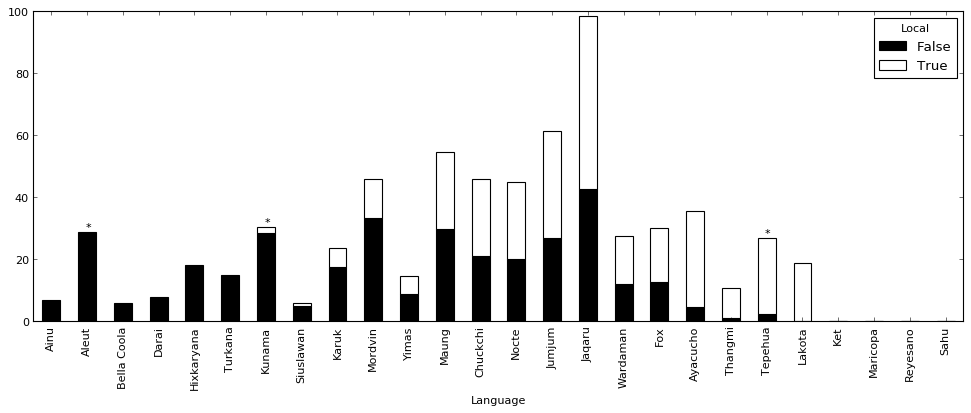

In [33]:
ax = cf.sort_values(by=('Cell ratio (norm)', True), kind='mergesort')['Cell ratio']\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray)
for x, lang in [(1, 'Aleut'), (6, 'Kunama'), (20, 'Tepehua')]:
    ax.annotate('*', (x - .05, cf.loc[lang, 'Cell ratio'].sum() + .5))
#ax.get_figure().savefig('results_local.pdf', bbox_inches='tight')

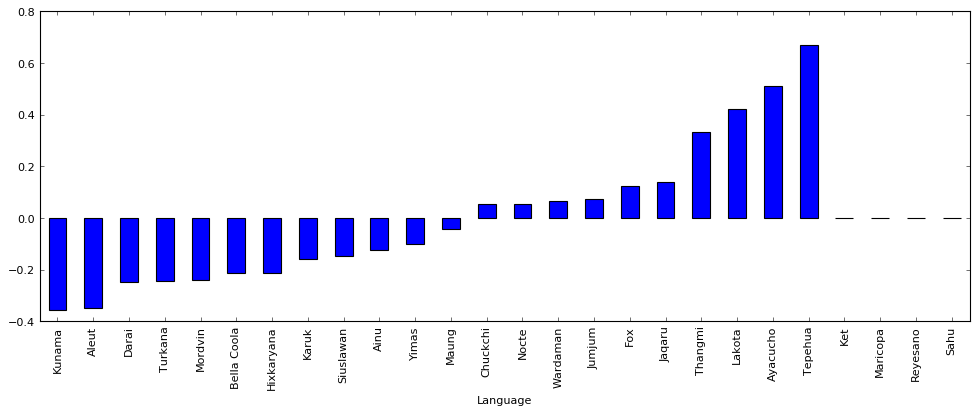

In [34]:
cells.reset_index().groupby('Language').apply(lambda x: pearsonr(x, 'Local', 'Ratio'))\
    ['r'].sort_values(kind='mergesort').plot.bar(figsize=(15, 5));

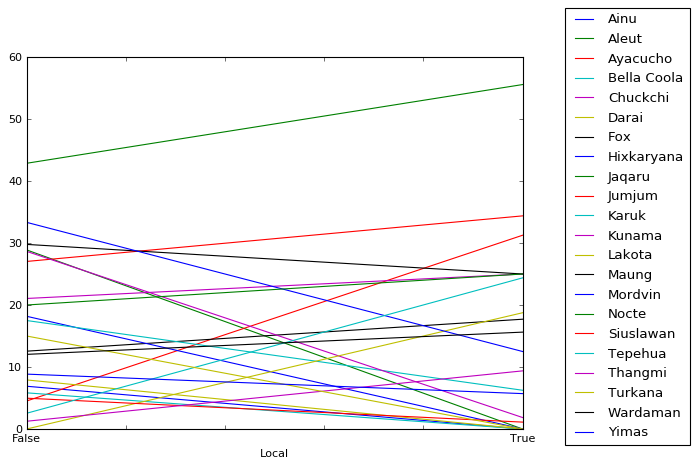

In [35]:
ax = cf['Cell ratio'].dropna().T.plot(figsize=(8, 6),legend=False)
ax.legend(bbox_to_anchor=(1.35, 1.15));

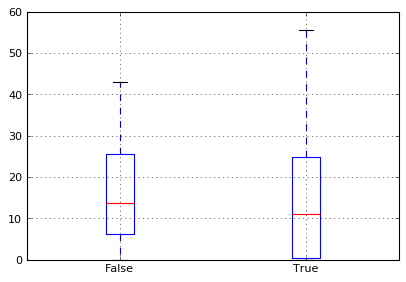

In [36]:
cf['Cell ratio'].boxplot(return_type='axes');

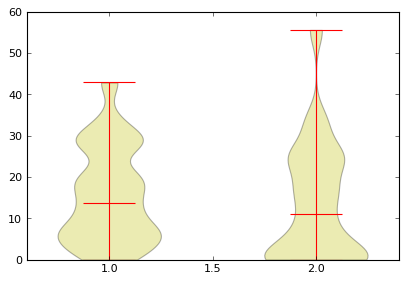

In [37]:
fig, ax = plt.subplots()
ax.violinplot(cf['Cell ratio'].dropna().values, showmedians=True, bw_method=.25);

In [38]:
cf[['Markers', 'Portmx', 'Ratio (norm)', 'Cell ratio (norm)']]

Markers       Portmx       Ratio (norm)            \
Local         False True   False True         False     True    
Language                                                        
Ainu             41    12      2     0     1.000000  0.000000   
Aleut            66    33     21     0     1.000000  0.000000   
Ayacucho         62    22      4     4     0.261905  0.738095   
Bella Coola      37    21      3     0     1.000000  0.000000   
Chuckchi         29    12      5     4     0.340909  0.659091   
Darai            53    20      4     0     1.000000  0.000000   
Fox             115    24     14     4     0.422111  0.577889   
Hixkaryana       22     6      4     0     1.000000  0.000000   
Jaqaru            9     7      3     4     0.368421  0.631579   
Jumjum           55    19     12     5     0.453280  0.546720   
Karuk            25    11      4     1     0.637681  0.362319   
Ket             196    22      0     0          NaN       NaN   
Kunama          139    47     37     1     0.925985  0.074015   
Lakota           42    20      0     2     0.000000  1.000000   
Maricopa         16    16      0     0          NaN       NaN   
Maung           255    18     69     5     0.493445  0.506555   
Mordvin          31     9     10     1     0.743802  0.256198   
Nocte            22     8      4     2     0.421053  0.578947   
Reyesano         32    12      0     0          NaN       NaN   
Sahu            195    24      0     0          NaN       NaN   
Siuslawan       178    61     12     1     0.804396  0.195604   
Tepehua          56    32      2     9     0.112676  0.887324   
Thangmi          39    18      1     3     0.133333  0.866667   
Turkana          28    10      4     0     1.000000  0.000000   
Wardaman         67    25      8     4     0.427350  0.572650   
Yimas           153    76     15     7     0.515604  0.484396   

            Cell ratio (norm)            
Local                   False     True   
Language                                 
Ainu                 1.000000  0.000000  
Aleut                1.000000  0.000000  
Ayacucho             0.126214  0.873786  
Bella Coola          1.000000  0.000000  
Chuckchi             0.457143  0.542857  
Darai                1.000000  0.000000  
Fox                  0.414802  0.585198  
Hixkaryana           1.000000  0.000000  
Jaqaru               0.435484  0.564516  
Jumjum               0.440136  0.559864  
Karuk                0.736842  0.263158  
Ket                       NaN       NaN  
Kunama               0.939297  0.060703  
Lakota               0.000000  1.000000  
Maricopa                  NaN       NaN  
Maung                0.543582  0.456418  
Mordvin              0.727273  0.272727  
Nocte                0.444444  0.555556  
Reyesano                  NaN       NaN  
Sahu                      NaN       NaN  
Siuslawan            0.817308  0.182692  
Tepehua              0.094244  0.905756  
Thangmi              0.117647  0.882353  
Turkana              1.000000  0.000000  
Wardaman             0.435146  0.564854  
Yimas                0.607977  0.392023

In [39]:
pd.DataFrame([pearsonr(cfp, 'Local', '%s (norm)' % c) for c in ['Perc', 'Ratio', 'Cell ratio']])

,r,p
Local & Perc (norm),-0.291594,0.054795
Local & Ratio (norm),-0.277682,0.068004
Local & Cell ratio (norm),-0.306743,0.042843


In [40]:
cfp[['%s (norm)' % c for c in ['Perc', 'Ratio', 'Cell ratio']]].corr()

,Perc (norm),Ratio (norm),Cell ratio (norm)
Perc (norm),1.000000,0.993548,0.983565
Ratio (norm),0.993548,1.000000,0.988801
Cell ratio (norm),0.983565,0.988801,1.000000


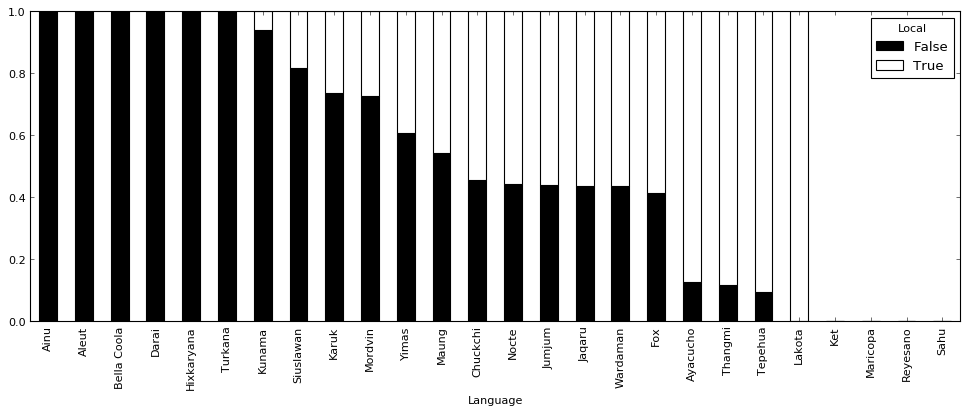

In [41]:
ax = cf['Cell ratio (norm)'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray)
#ax.get_figure().savefig('results_local_norm.pdf', bbox_inches='tight')

In [42]:
cf['Cell ratio (norm)'].sum().to_frame('Cell ratio (norm)').T

Local,False,True
Cell ratio (norm),13.337538,8.662462


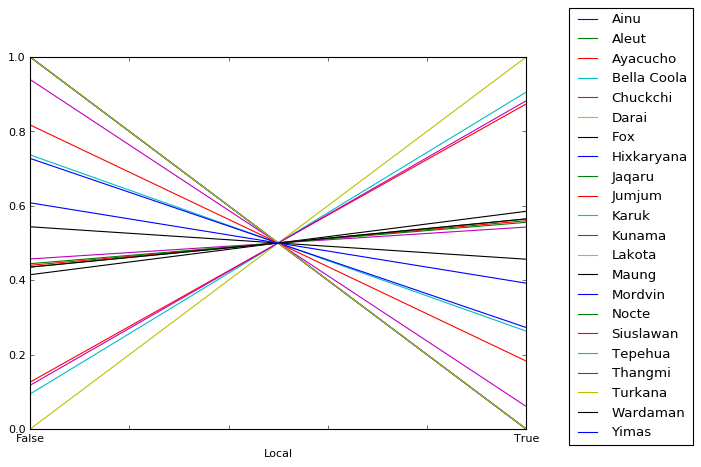

In [43]:
ax = cf['Cell ratio (norm)'].dropna().T.plot(figsize=(8, 6),legend=False)
ax.legend(bbox_to_anchor=(1.35, 1.15));

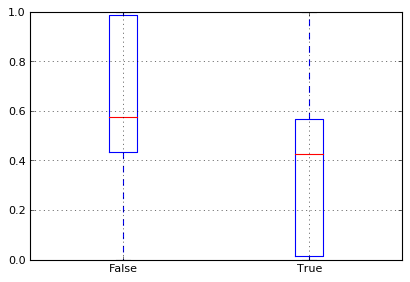

In [44]:
cf['Cell ratio (norm)'].boxplot(return_type='axes');

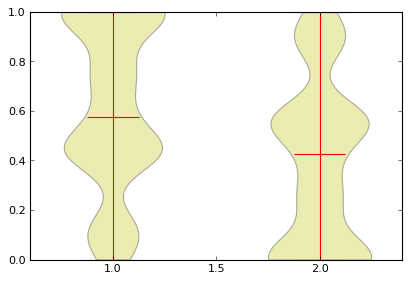

In [45]:
fig, ax = plt.subplots()
ax.violinplot(cf['Cell ratio (norm)'].dropna().values, showmedians=True, bw_method=.25);

# Direct

In [46]:
ctd = crosstab(df[df['Trans']], ['Language', 'Direct'], 'Portmx', margins=False)
ctd.join(ctd.groupby(level='Language').apply(fisher_exact))\
    .rename_axis('Portmx', axis=1).query('p <= .05')

Portmx           False  True       odds         p
Language Direct                                  
Aleut    False      42     0        inf  0.000002
         True       36    21        inf  0.000002
Fox      False      53    14   0.222689  0.010231
         True       68     4   0.222689  0.010231
Jumjum   False      43     8   3.455357  0.037495
         True       14     9   3.455357  0.037495
Yimas    False      86     1  14.925620  0.000332
         True      121    21  14.925620  0.000332

In [47]:
cfd = cells.reset_index().groupby(['Language', 'Direct']).agg(OrderedDict([('Cell', 'size'),
    ('Hasp', ntrue), ('Markers', 'sum'), ('Portmx', 'sum'), ('Ratio', 'mean')]))\
    .rename(columns={'Cell': 'Cells', 'Ratio': 'Cell ratio'})
cfd.insert(2, 'Perc', 100 * cfd['Hasp'] / cfd['Cells'])
cfd.insert(5, 'Ratio', 100 * cfd['Portmx'] / cfd['Markers'])
nfd = cfd[['Perc', 'Ratio', 'Cell ratio']]; nfd /= nfd.sum(level='Language')
cfd = cfd.join(nfd, rsuffix=' (norm)')
cfd.loc[cfd['Perc (norm)'].isnull(), ['Perc', 'Ratio', 'Cell ratio']] = None
cfdp = cfd.reset_index('Direct')
cfd = cfd.unstack('Direct')
cfd.loc[:, :'Cell ratio']

Cells        Hasp             Perc            Markers        \
Direct      False True  False True       False      True    False True    
Language                                                                  
Ainu           18    19     0     2   0.000000  10.526316      29    24   
Aleut          27    36     0    16   0.000000  44.444444      42    57   
Ayacucho       14    18     4     4  28.571429  22.222222      47    37   
Bella Coola    12    16     2     1  16.666667   6.250000      29    29   
Chuckchi       11    16     1     8   9.090909  50.000000      18    23   
Darai          12    16     2     2  16.666667  12.500000      26    47   
Fox            18    22    14     4  77.777778  18.181818      67    72   
Hixkaryana     10    18     2     2  20.000000  11.111111      10    18   
Jaqaru          5     5     4     2  80.000000  40.000000       9     7   
Jumjum         16    20     7     8  43.750000  40.000000      51    23   
Karuk          12    16     2     3  16.666667  18.750000      18    18   
Ket            28    64     0     0        NaN        NaN      76   142   
Kunama         33    42     9    19  27.272727  45.238095      64   122   
Lakota         14    17     0     2   0.000000  11.764706      29    33   
Maricopa       12    12     0     0        NaN        NaN      20    12   
Maung          34    70    12    49  35.294118  70.000000      83   190   
Mordvin        12    16     3     7  25.000000  43.750000      14    26   
Nocte          12    16     2     4  16.666667  25.000000      12    18   
Reyesano       12    16     0     0        NaN        NaN      24    20   
Sahu           34    70     0     0        NaN        NaN      73   146   
Siuslawan      33    42     4     6  12.121212  14.285714     108   131   
Tepehua        14    17     3     5  21.428571  29.411765      46    42   
Thangmi        12    16     2     1  16.666667   6.250000      25    32   
Turkana        12    16     0     4   0.000000  25.000000      18    20   
Wardaman       16    19     2     9  12.500000  47.368421      47    45   
Yimas          27    36     1    15   3.703704  41.666667      87   142   

            Portmx            Ratio            Cell ratio             
Direct       False True       False      True       False      True   
Language                                                              
Ainu             0     2   0.000000   8.333333   0.000000  10.526316  
Aleut            0    21   0.000000  36.842105   0.000000  36.111111  
Ayacucho         4     4   8.510638  10.810811   7.738095  13.888889  
Bella Coola      2     1   6.896552   3.448276   5.555556   3.125000  
Chuckchi         1     8   5.555556  34.782609   4.545455  34.375000  
Darai            2     2   7.692308   4.255319   8.333333   3.645833  
Fox             14     4  20.895522   5.555556  22.314815   6.439394  
Hixkaryana       2     2  20.000000  11.111111  20.000000  11.111111  
Jaqaru           5     2  55.555556  28.571429  63.333333  30.000000  
Jumjum           8     9  15.686275  39.130435  17.604167  37.500000  
Karuk            2     3  11.111111  16.666667   8.333333  18.750000  
Ket              0     0        NaN        NaN        NaN        NaN  
Kunama          11    27  17.187500  22.131148  18.181818  25.396825  
Lakota           0     2   0.000000   6.060606   0.000000   8.823529  
Maricopa         0     0        NaN        NaN        NaN        NaN  
Maung           16    58  19.277108  30.526316  18.627451  34.642857  
Mordvin          4     7  28.571429  26.923077  22.222222  31.250000  
Nocte            2     4  16.666667  22.222222  16.666667  25.000000  
Reyesano         0     0        NaN        NaN        NaN        NaN  
Sahu             0     0        NaN        NaN        NaN        NaN  
Siuslawan        4     9   3.703704   6.870229   2.979798   4.880952  
Tepehua          6     5  13.043478  11.904762   8.571429   7.843137  
Thangmi          3     1  12.000000   3.125000   6.250000   1

In [48]:
pd.DataFrame([pearsonr(cfdp, 'Direct', c) for c in ['Perc', 'Ratio', 'Cell ratio']])

,r,p
Direct & Perc,0.178565,0.246163
Direct & Ratio,0.215627,0.159804
Direct & Cell ratio,0.242860,0.112182


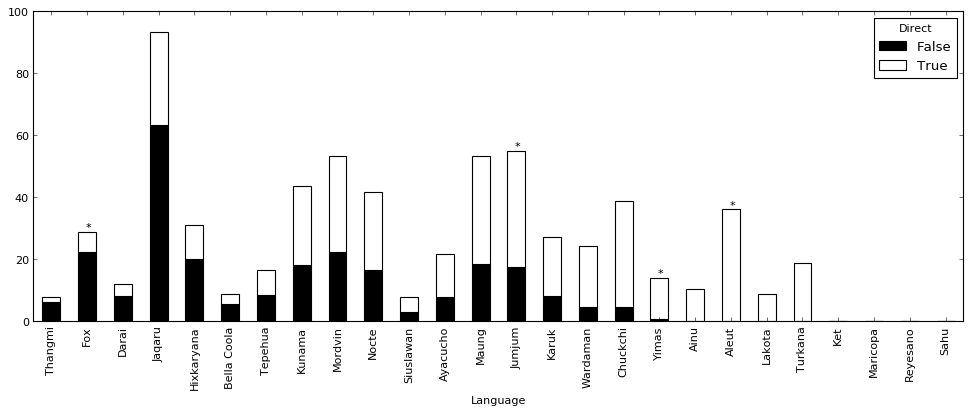

In [49]:
ax = cfd.sort_values(by=('Cell ratio (norm)', True), kind='mergesort')['Cell ratio']\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray)
for x, lang in [(19, 'Aleut'), (1, 'Fox'), (13, 'Jumjum'), (17, 'Yimas')]:
    ax.annotate('*', (x - .05, cfd.loc[lang, 'Cell ratio'].sum() + .5))
#ax.get_figure().savefig('results_direct.pdf', bbox_inches='tight')

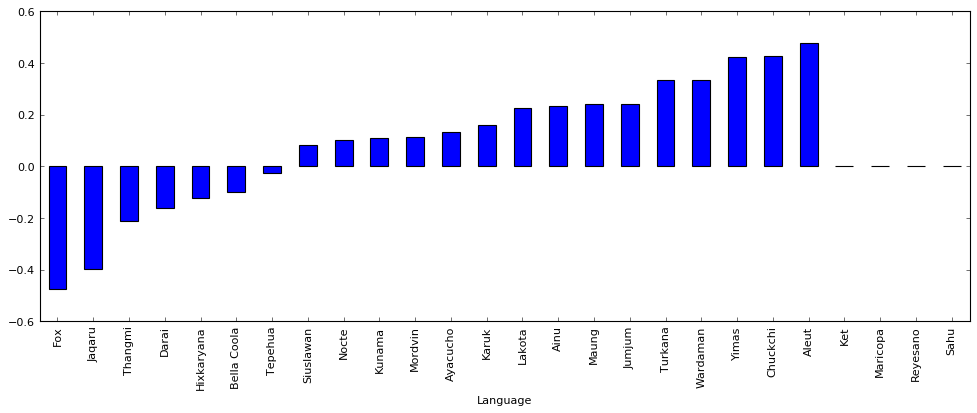

In [50]:
cells.reset_index().groupby('Language').apply(lambda x: pearsonr(x, 'Direct', 'Ratio'))\
    ['r'].sort_values(kind='mergesort').plot.bar(figsize=(15, 5));

In [51]:
cfd[['Markers', 'Portmx', 'Ratio (norm)', 'Cell ratio (norm)']]

Markers       Portmx       Ratio (norm)            \
Direct        False True   False True         False     True    
Language                                                        
Ainu             29    24      0     2     0.000000  1.000000   
Aleut            42    57      0    21     0.000000  1.000000   
Ayacucho         47    37      4     4     0.440476  0.559524   
Bella Coola      29    29      2     1     0.666667  0.333333   
Chuckchi         18    23      1     8     0.137725  0.862275   
Darai            26    47      2     2     0.643836  0.356164   
Fox              67    72     14     4     0.789969  0.210031   
Hixkaryana       10    18      2     2     0.642857  0.357143   
Jaqaru            9     7      5     2     0.660377  0.339623   
Jumjum           51    23      8     9     0.286159  0.713841   
Karuk            18    18      2     3     0.400000  0.600000   
Ket              76   142      0     0          NaN       NaN   
Kunama           64   122     11    27     0.437134  0.562866   
Lakota           29    33      0     2     0.000000  1.000000   
Maricopa         20    12      0     0          NaN       NaN   
Maung            83   190     16    58     0.387064  0.612936   
Mordvin          14    26      4     7     0.514851  0.485149   
Nocte            12    18      2     4     0.428571  0.571429   
Reyesano         24    20      0     0          NaN       NaN   
Sahu             73   146      0     0          NaN       NaN   
Siuslawan       108   131      4     9     0.350267  0.649733   
Tepehua          46    42      6     5     0.522822  0.477178   
Thangmi          25    32      3     1     0.793388  0.206612   
Turkana          18    20      0     4     0.000000  1.000000   
Wardaman         47    45      3     9     0.241935  0.758065   
Yimas            87   142      1    21     0.072118  0.927882   

            Cell ratio (norm)            
Direct                  False     True   
Language                                 
Ainu                 0.000000  1.000000  
Aleut                0.000000  1.000000  
Ayacucho             0.357798  0.642202  
Bella Coola          0.640000  0.360000  
Chuckchi             0.116788  0.883212  
Darai                0.695652  0.304348  
Fox                  0.776054  0.223946  
Hixkaryana           0.642857  0.357143  
Jaqaru               0.678571  0.321429  
Jumjum               0.319471  0.680529  
Karuk                0.307692  0.692308  
Ket                       NaN       NaN  
Kunama               0.417219  0.582781  
Lakota               0.000000  1.000000  
Maricopa                  NaN       NaN  
Maung                0.349678  0.650322  
Mordvin              0.415584  0.584416  
Nocte                0.400000  0.600000  
Reyesano                  NaN       NaN  
Sahu                      NaN       NaN  
Siuslawan            0.379073  0.620927  
Tepehua              0.522184  0.477816  
Thangmi              0.800000  0.200000  
Turkana              0.000000  1.000000  
Wardaman             0.191919  0.808081  
Yimas                0.065436  0.934564

In [52]:
pd.DataFrame([pearsonr(cfdp, 'Direct', '%s (norm)' % c) for c in ['Perc', 'Ratio', 'Cell ratio']])

,r,p
Direct & Perc (norm),0.406578,0.006168
Direct & Ratio (norm),0.416424,0.004928
Direct & Cell ratio (norm),0.457289,0.001804


In [53]:
cfdp[['%s (norm)' % c for c in ['Perc', 'Ratio', 'Cell ratio']]].corr()

,Perc (norm),Ratio (norm),Cell ratio (norm)
Perc (norm),1.000000,0.958776,0.955347
Ratio (norm),0.958776,1.000000,0.990275
Cell ratio (norm),0.955347,0.990275,1.000000


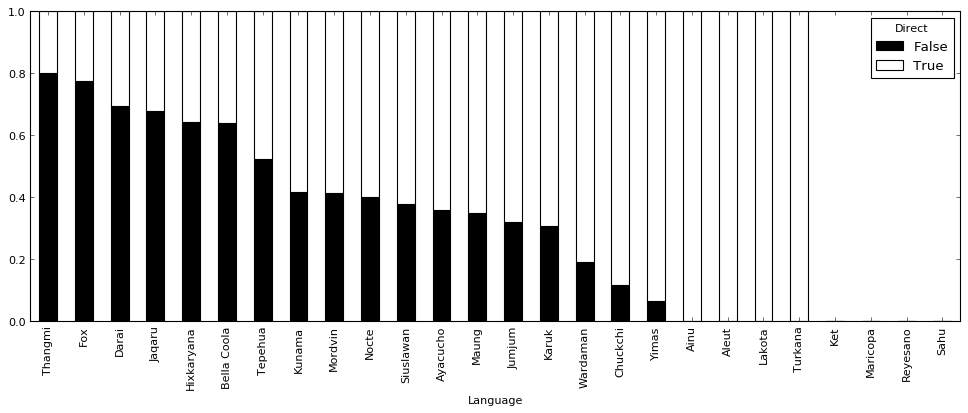

In [54]:
ax = cfd['Cell ratio (norm)'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray)
#ax.get_figure().savefig('results_direct_norm.pdf', bbox_inches='tight')

In [55]:
cfd['Cell ratio (norm)'].sum().to_frame('Cell ratio (norm)').T

Direct,False,True
Cell ratio (norm),8.075977,13.924023
